In [3]:
import os
import torch
import wfdb
import numpy as np
import neurokit2 as nk
from tqdm import tqdm

train = [101, 106, 108, 109, 112, 114, 115, 116, 118, 119, 122, 124, 201, 203, 205, 207, 208, 209, 215, 220, 223, 230]
test = [100, 103, 105, 111, 113, 117, 121, 123, 200, 202, 210, 212, 213, 214, 219, 221, 222, 228, 231, 232, 233, 234]
val = [102, 104, 107, 217]
all = train + test
data_folder = 'data/raw'

In [4]:
signals_train = []
for i in tqdm(train):
    signal, _ = wfdb.rdsamp(os.path.join(data_folder, f'{i}'))
    signals_train.append(signal)

signals_test = []
for i in tqdm(test):
    signal, _ = wfdb.rdsamp(os.path.join(data_folder, f'{i}'))
    signals_test.append(signal)

signals_val = []
for i in tqdm(val):
    signal, _ = wfdb.rdsamp(os.path.join(data_folder, f'{i}'))
    signals_val.append(signal)

print('Signals loaded')

annotations_train = []
for i in tqdm(train):
    annotation = wfdb.rdann(os.path.join(data_folder, f'{i}'), 'atr')
    annotations_train.append(annotation)

annotations_test = []
for i in tqdm(test):
    annotation = wfdb.rdann(os.path.join(data_folder, f'{i}'), 'atr')
    annotations_test.append(annotation)

annotations_val = []
for i in tqdm(val):
    annotation = wfdb.rdann(os.path.join(data_folder, f'{i}'), 'atr')
    annotations_val.append(annotation)

print('Annotations loaded')

100%|██████████| 4/4 [00:00<00:00, 61.17it/s]


Signals loaded


100%|██████████| 4/4 [00:00<00:00, 219.79it/s]

Annotations loaded


In [13]:
from neurokit2 import ecg_clean
from ecg_preprocessing import *

valid_annotations = ['N', 'L', 'R', 'e', 'j', 'A', 'a', 'J', 'S', 'V', 'E', 'F', '/', 'f', 'Q']

# for each patient, divide the signal every half peaks
def convert_label(symbol):
    if symbol in ['N', 'L', 'R', 'e', 'j']: 
        return 'N'
    elif symbol in ['A', 'a', 'J', 'S']:
        return 'S'  # Supraventricular ectopic
    elif symbol in ['V', 'E']: 
        return 'V'  # Ventricular ectopic
    elif symbol in ['F']: 
       return 'F'  # Fusion
    elif symbol in ['/', 'f', 'Q']:
        return 'Q'  # Unknown
    else:
        print(symbol)
        raise(f'Unknown symbol {symbol}') 
    
def normalize_01(signal):
    return signal / np.abs(signal).max()

def normalize_normal(signal):
    return (signal - signal.mean()) / signal.std()

def preprocess_nk_clean(signal):
    signal[:, 0] = ecg_clean(signal[:, 0], sampling_rate=360)
    signal[:, 1] = ecg_clean(signal[:, 1], sampling_rate=360)
    return signal


def create_samples(signals, annotations, data_folder='data/preprocessed_base/', subset='train', in_memory=False, preprocessing_method=None, normalization='normal', classes=['N', 'S', 'V', 'F', 'Q']):
    """
    Create samples from the signals and annotations

    Args:
    - signals: list of numpy arrays with the signals
    - annotations: list of wfdb annotations
    - data_folder: folder to save the samples
    - subset: subset name (train, test, val)
    - in_memory: if True, return the samples in memory without saving to disk
    - preprocessing_method: method to preprocess the signal (None, 'nk_clean', 'bas_wander')
    - normalization: normalization method ('normal', '01')
    - classes: list of classes to consider (default ['N', 'S', 'V', 'F', 'Q'])
    """
    margin_perc = 0.1
    os.makedirs(data_folder + subset, exist_ok=True)
    processed_samples = []
    for i, (signal, annotation) in tqdm(enumerate(zip(signals, annotations))):
        peaks_orig = annotation.sample
        labels_orig = annotation.symbol

        if preprocessing_method == 'nk_clean':
            signal = preprocess_nk_clean(signal)
        elif preprocessing_method == 'bas_wander':
            signal[:, 0] -= baseline_als(signal[:, 0], lam=1e7, p=0.3, niter=5)
            signal[:, 1] -= baseline_als(signal[:, 1], lam=1e7, p=0.3, niter=5)

        
        valid = [(p, l) for l, p in zip(labels_orig, peaks_orig) if l in valid_annotations]
        # unzip the peaks and labels
        peaks, labels = zip(*valid)

        invalid = [(p, l) for l, p in zip(labels_orig, peaks_orig) if l not in valid_annotations]
        

        # count the number of different labels
        #label_count = {l: labels.count(l) for l in set(labels)}
        #print(f'Patient {i} has {label_count}')

        for j in range(0, len(peaks) - 1):
            # getting the points in the between of the two peaks
            start = 0 if j == 0 else (peaks[j] + peaks[j - 1]) // 2
            end = (peaks[j + 1] + peaks[j]) // 2 

            # add a margin to the signal, considering the space between the peaks
            margin_start = 0 if j == 0 else int((peaks[j] - peaks[j - 1]) * margin_perc)
            margin_end = int((peaks[j + 1] - peaks[j]) * margin_perc)

            start = max(0, start - margin_start)
            end = min(len(signal), end + margin_end)


            # get non valid annotations within the margin
            for inv_peak, inv_label in invalid:
                # invalid peak ']' at the beginning of the signal
                if (inv_label == ']' or inv_label+ '+') and inv_peak > start and inv_peak < peaks[j]:
                    start = inv_peak + 1
                # invalid peak '[' at the end of the signal
                if (inv_label == '[' or inv_label+ '+') and inv_peak < end and inv_peak > peaks[j]:
                    #print(f'Invalid peak at the end of the signal {inv_peak}')
                    end = inv_peak - 1
                    

            signal_part = signal[start:end]
            if normalization == '01':
                signal_part = normalize_01(signal_part)
            elif normalization == 'normal':
                signal_part = normalize_normal(signal_part) 

            label = convert_label(labels[j])
            # skip the sample if the label is not in the classes
            if label not in classes:
                continue

            if not in_memory:
                # create file
                torch.save(torch.tensor(signal_part), os.path.join(data_folder + subset, f'{i}_{j}.pt'))   
                # Save the label to a CSV file
                with open(os.path.join(data_folder + subset, 'labels.csv'), 'a') as f:
                    f.write(f'{i}_{j},{label}\n')
            else:
                processed_samples.append((signal_part, label))

            #if len(signal_part) > 1000:
            #    print(f'Patient {i} has a sample with {len(signal_part)} samples at index {peaks[j]} from {start} to {end}')
        
    if in_memory: return processed_samples

#create_samples(signals_train, annotations_train, data_folder='data/preprocessed_base/', subset='train')
#create_samples(signals_test, annotations_test, data_folder='data/preprocessed_base/', subset='test')
#create_samples(signals_val, annotations_val, data_folder='data/preprocessed_base/', subset='val')

#create_samples(signals_train, annotations_train, data_folder='data/preprocessed_nk_clean/', subset='train', preprocessing_method='nk_clean')
#create_samples(signals_test, annotations_test, data_folder='data/preprocessed_nk_clean/', subset='test', preprocessing_method='nk_clean')
#create_samples(signals_val, annotations_val, data_folder='data/preprocessed_nk_clean/', subset='val', preprocessing_method='nk_clean')

#create_samples(signals_train, annotations_train, data_folder='data/preprocessed_raw/', subset='train', preprocessing_method=None, normalization=None)
#create_samples(signals_test, annotations_test, data_folder='data/preprocessed_raw/', subset='test', preprocessing_method=None, normalization=None)
#create_samples(signals_val, annotations_val, data_folder='data/preprocessed_raw/', subset='val', preprocessing_method=None, normalization=None)


#create_samples(signals_train, annotations_train, data_folder='data/preprocessed_01/', subset='train', preprocessing_method=None, normalization='01')
#create_samples(signals_test, annotations_test, data_folder='data/preprocessed_01/', subset='test', preprocessing_method=None, normalization='01')
#create_samples(signals_val, annotations_val, data_folder='data/preprocessed_01/', subset='val', preprocessing_method=None, normalization='01')

create_samples(signals_train, annotations_train, data_folder='data/preprocessed_bas_wander/', subset='train', preprocessing_method='bas_wander', normalization=None)
create_samples(signals_test, annotations_test, data_folder='data/preprocessed_bas_wander/', subset='test', preprocessing_method='bas_wander', normalization=None)
create_samples(signals_val, annotations_val, data_folder='data/preprocessed_bas_wander/', subset='val', preprocessing_method='bas_wander', normalization=None)

22it [01:18,  3.58s/it]
22it [01:19,  3.62s/it]
4it [00:14,  3.60s/it]


In [6]:
# get some examples for debugging
#processed_samples_train = create_samples(signals_train, annotations_train, data_folder='data/preprocessed_base/', subset='train', in_memory=True, preprocessing_method=None, normalization=None)
#processed_samples_test = create_samples(signals_test, annotations_test, data_folder='data/preprocessed_base/', subset='test', in_memory=True, preprocessing_method=None, normalization=None)
#processed_samples_val = create_samples(signals_val, annotations_val, data_folder='data/preprocessed_base/', subset='val', in_memory=True, preprocessing_method=None, normalization=None)

#processed_samples_train = create_samples(signals_train, annotations_train, data_folder='data/preprocessed_nk_clean/', subset='train', in_memory=True, preprocessing_method='nk_clean')
#processed_samples_test = create_samples(signals_test, annotations_test, data_folder='data/preprocessed_nk_clean/', subset='test', in_memory=True, preprocessing_method='nk_clean')
#processed_samples_val = create_samples(signals_val, annotations_val, data_folder='data/preprocessed_nk_clean/', subset='val', in_memory=True, preprocessing_method='nk_clean')

#processed_samples_train = create_samples(signals_train, annotations_train, data_folder='data/preprocessed_raw/', subset='train', in_memory=True, preprocessing_method=None, normalization=None)
#processed_samples_test = create_samples(signals_test, annotations_test, data_folder='data/preprocessed_raw/', subset='test', in_memory=True, preprocessing_method=None, normalization=None)
#processed_samples_val = create_samples(signals_val, annotations_val, data_folder='data/preprocessed_raw/', subset='val', in_memory=True, preprocessing_method=None, normalization=None)

#processed_samples_train = create_samples(signals_train, annotations_train, data_folder='data/preprocessed_01/', subset='train', in_memory=True, preprocessing_method=None, normalization='01')
#processed_samples_test = create_samples(signals_test, annotations_test, data_folder='data/preprocessed_01/', subset='test', in_memory=True, preprocessing_method=None, normalization='01')
#processed_samples_val = create_samples(signals_val, annotations_val, data_folder='data/preprocessed_01/', subset='val', in_memory=True, preprocessing_method=None, normalization='01')

processed_samples_train = create_samples(signals_train, annotations_train, data_folder='data/preprocessed_bas_wander/', subset='train', in_memory=True, preprocessing_method='bas_wander', normalization=None)
processed_samples_test = create_samples(signals_test, annotations_test, data_folder='data/preprocessed_bas_wander/', subset='test', in_memory=True, preprocessing_method='bas_wander', normalization=None)
processed_samples_val = create_samples(signals_val, annotations_val, data_folder='data/preprocessed_bas_wander/', subset='val', in_memory=True, preprocessing_method='bas_wander', normalization=None)


22it [01:12,  3.32s/it]
22it [01:13,  3.35s/it]
4it [00:13,  3.33s/it]


In [7]:
print(f'Patient 15 corresponds to recoded patient {train[15]}')
print(f'Patient 12 corresponds to recoded patient {train[12]}')
print(f'Patient 19 corresponds to recoded patient {test[19]}')

Patient 15 corresponds to recoded patient 207
Patient 12 corresponds to recoded patient 201
Patient 19 corresponds to recoded patient 232


Counter({'N': 45845, 'V': 3788, 'S': 943, 'F': 415, 'Q': 8})
Counter({'N': 44238, 'V': 3221, 'S': 1836, 'F': 388, 'Q': 7})
Counter({'Q': 8024, 'N': 506, 'V': 227})
Average length: 332.47883291829254
Max length: 1244
Min length: 89
Samples longer than 1000:  3


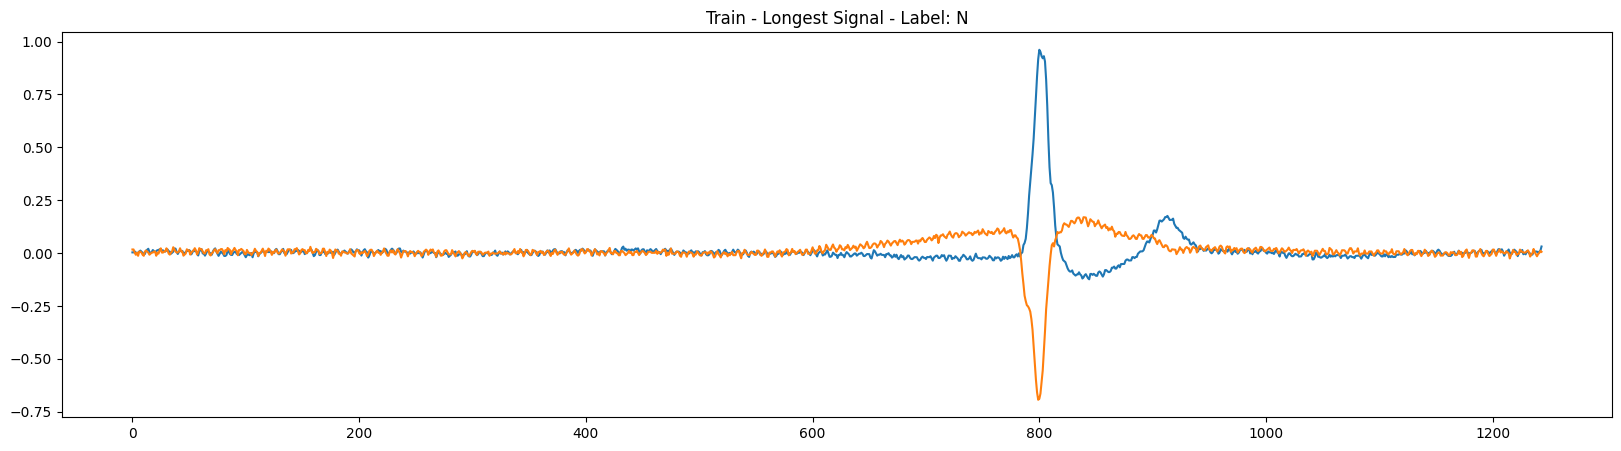

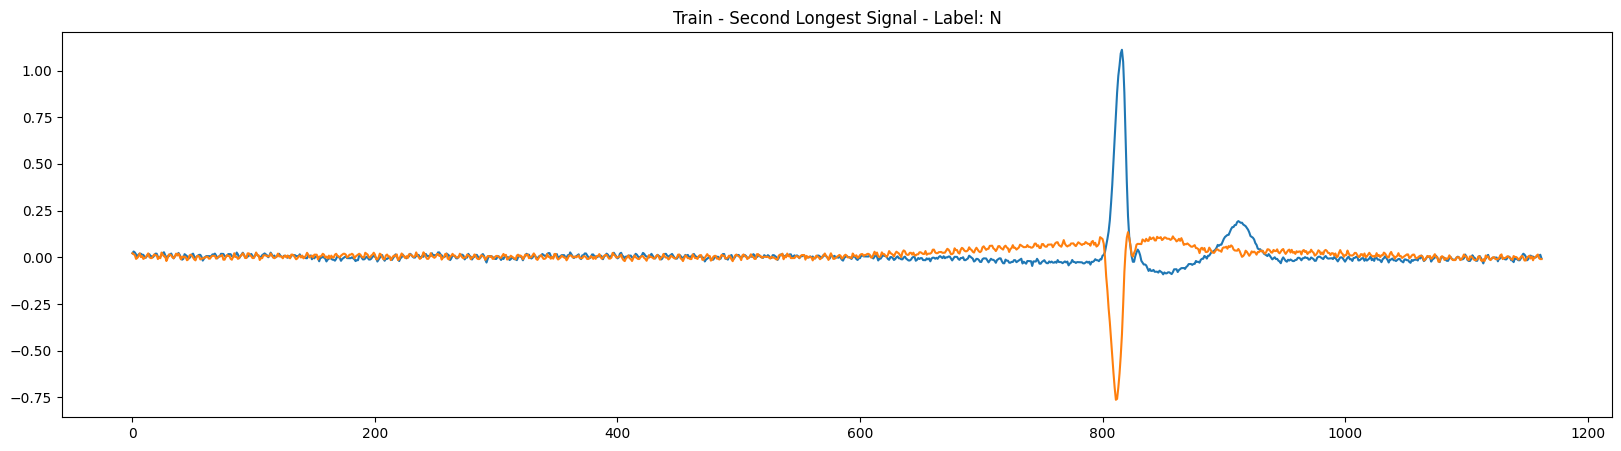

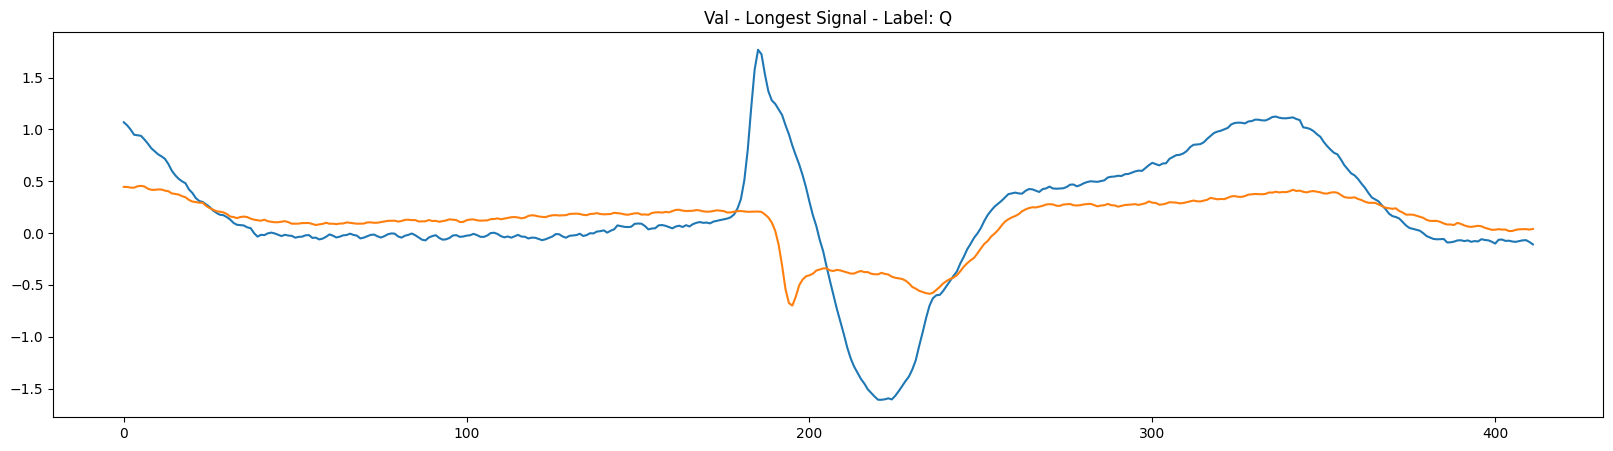

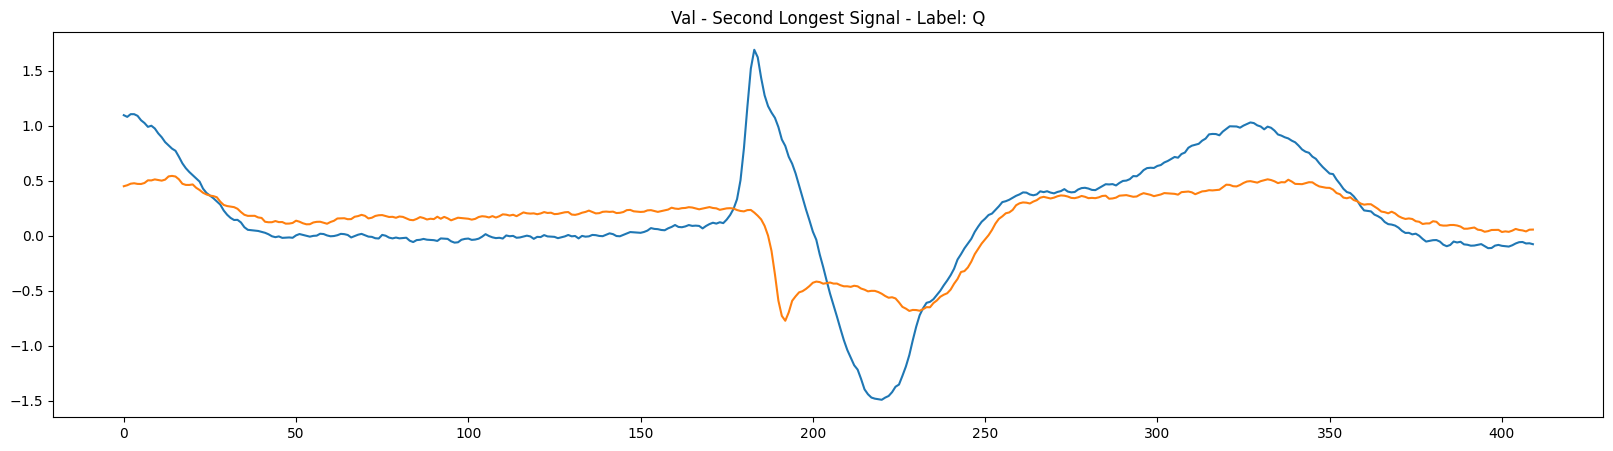

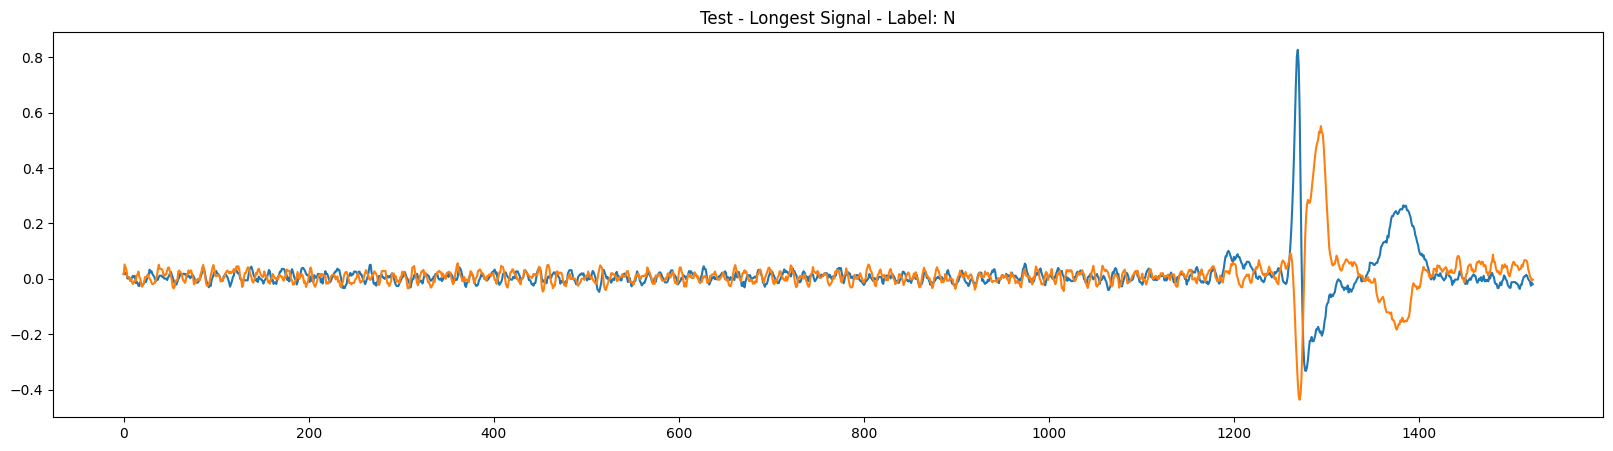

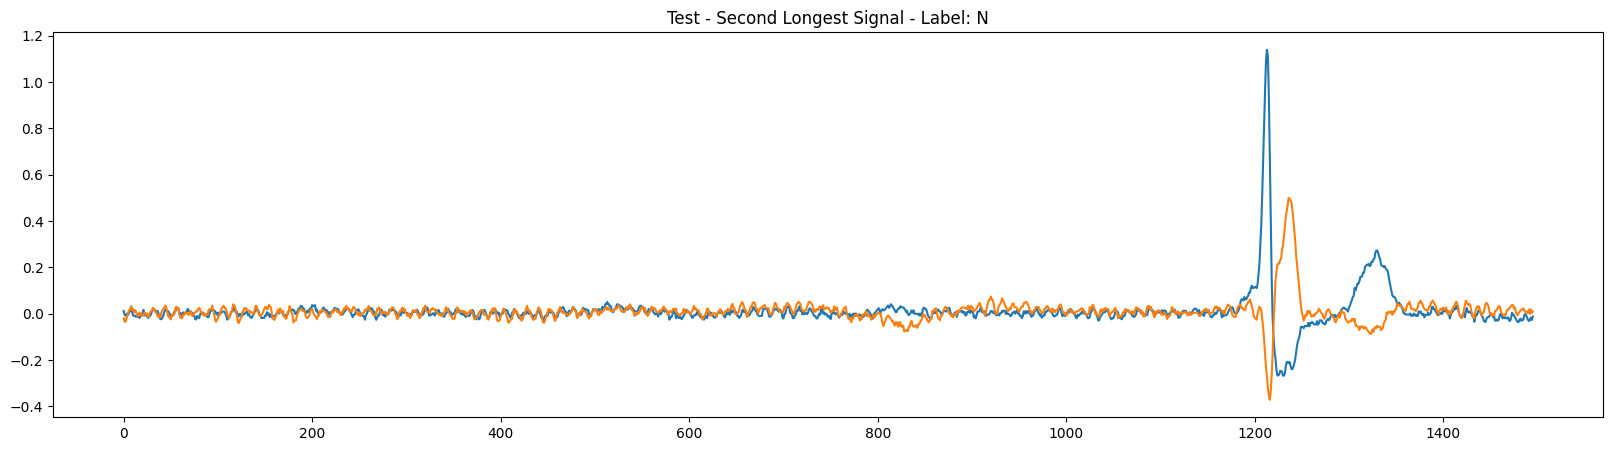

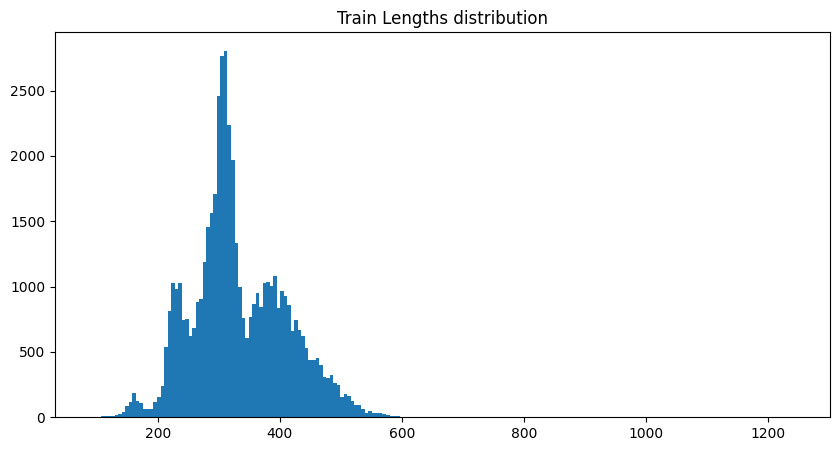

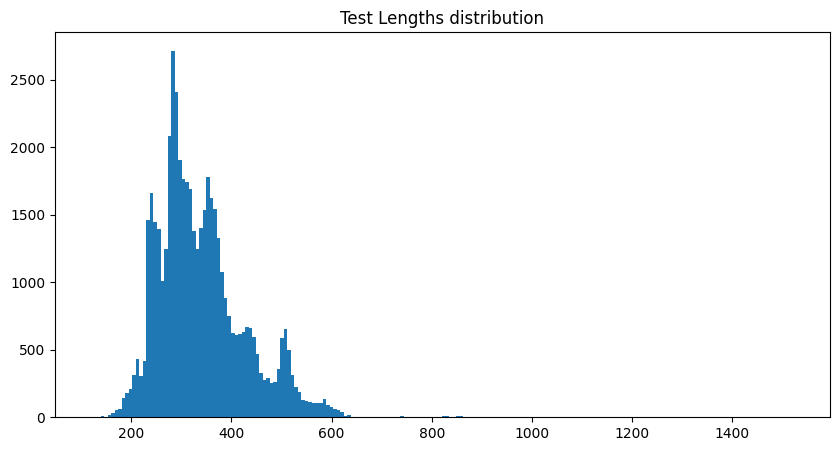

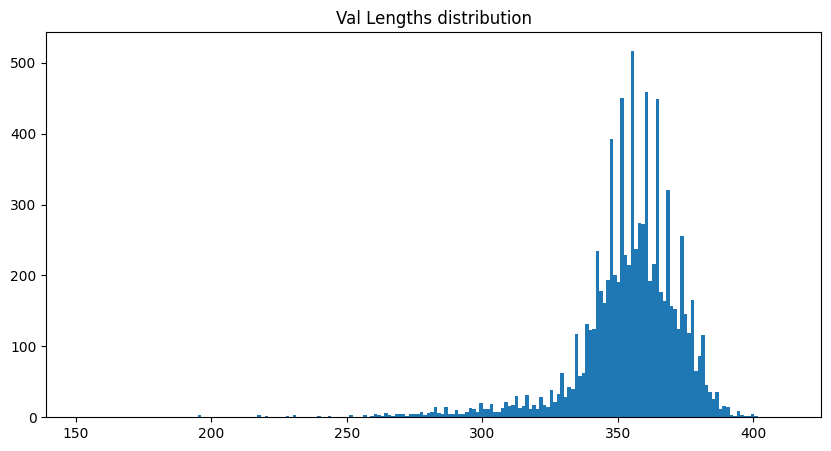

In [8]:
# count the number of samples for each class
from collections import Counter
labels = [label for _, label in processed_samples_train]
print(Counter(labels))

labels = [label for _, label in processed_samples_test]
print(Counter(labels))

labels = [label for _, label in processed_samples_val]
print(Counter(labels))

# measure the average length of the samples as well as maximum and minimum
lengths = [len(signal) for signal, _ in processed_samples_train]
print(f'Average length: {np.mean(lengths)}')
print(f'Max length: {np.max(lengths)}')
print(f'Min length: {np.min(lengths)}')



# plot the longest signal
import matplotlib.pyplot as plt

# plot the longest signal from train
signal, label = processed_samples_train[np.argmax(lengths)]
plt.figure(figsize=(20, 5))
plt.plot(signal)
plt.title(f'Train - Longest Signal - Label: {label}')

# plot the second longest signal from train
signal, label = processed_samples_train[np.argsort(lengths)[-2]]
plt.figure(figsize=(20, 5))
plt.plot(signal)
plt.title(f'Train - Second Longest Signal - Label: {label}')

# plot the longest signal from val
lengths_val = [len(signal) for signal, _ in processed_samples_val]
signal, label = processed_samples_val[np.argmax(lengths_val)]
plt.figure(figsize=(20, 5))
plt.plot(signal)
plt.title(f'Val - Longest Signal - Label: {label}')

# plot the second longest signal from val
signal, label = processed_samples_val[np.argsort(lengths_val)[-2]]
plt.figure(figsize=(20, 5))
plt.plot(signal)
plt.title(f'Val - Second Longest Signal - Label: {label}')


# plot the longest signal from test
lengths_test = [len(signal) for signal, _ in processed_samples_test]
signal, label = processed_samples_test[np.argmax(lengths_test)]
plt.figure(figsize=(20, 5))
plt.plot(signal)
plt.title(f'Test - Longest Signal - Label: {label}')

# plot the second longest signal from test
signal, label = processed_samples_test[np.argsort(lengths_test)[-2]]
plt.figure(figsize=(20, 5))
plt.plot(signal)
plt.title(f'Test - Second Longest Signal - Label: {label}')
# plot the distribution of the lengths for train
plt.figure(figsize=(10, 5))
plt.hist(lengths, bins=200)
plt.title('Train Lengths distribution')

# plot the distribution of the lengths for test
plt.figure(figsize=(10, 5))
plt.hist(lengths_test, bins=200)
plt.title('Test Lengths distribution')

# plot the distribution of the lengths for val
plt.figure(figsize=(10, 5))
plt.hist(lengths_val, bins=200)
plt.title('Val Lengths distribution')

# print the number of samples that has len bigger than 500
print('Samples longer than 1000: ', len([l for l in lengths if l > 1000]))


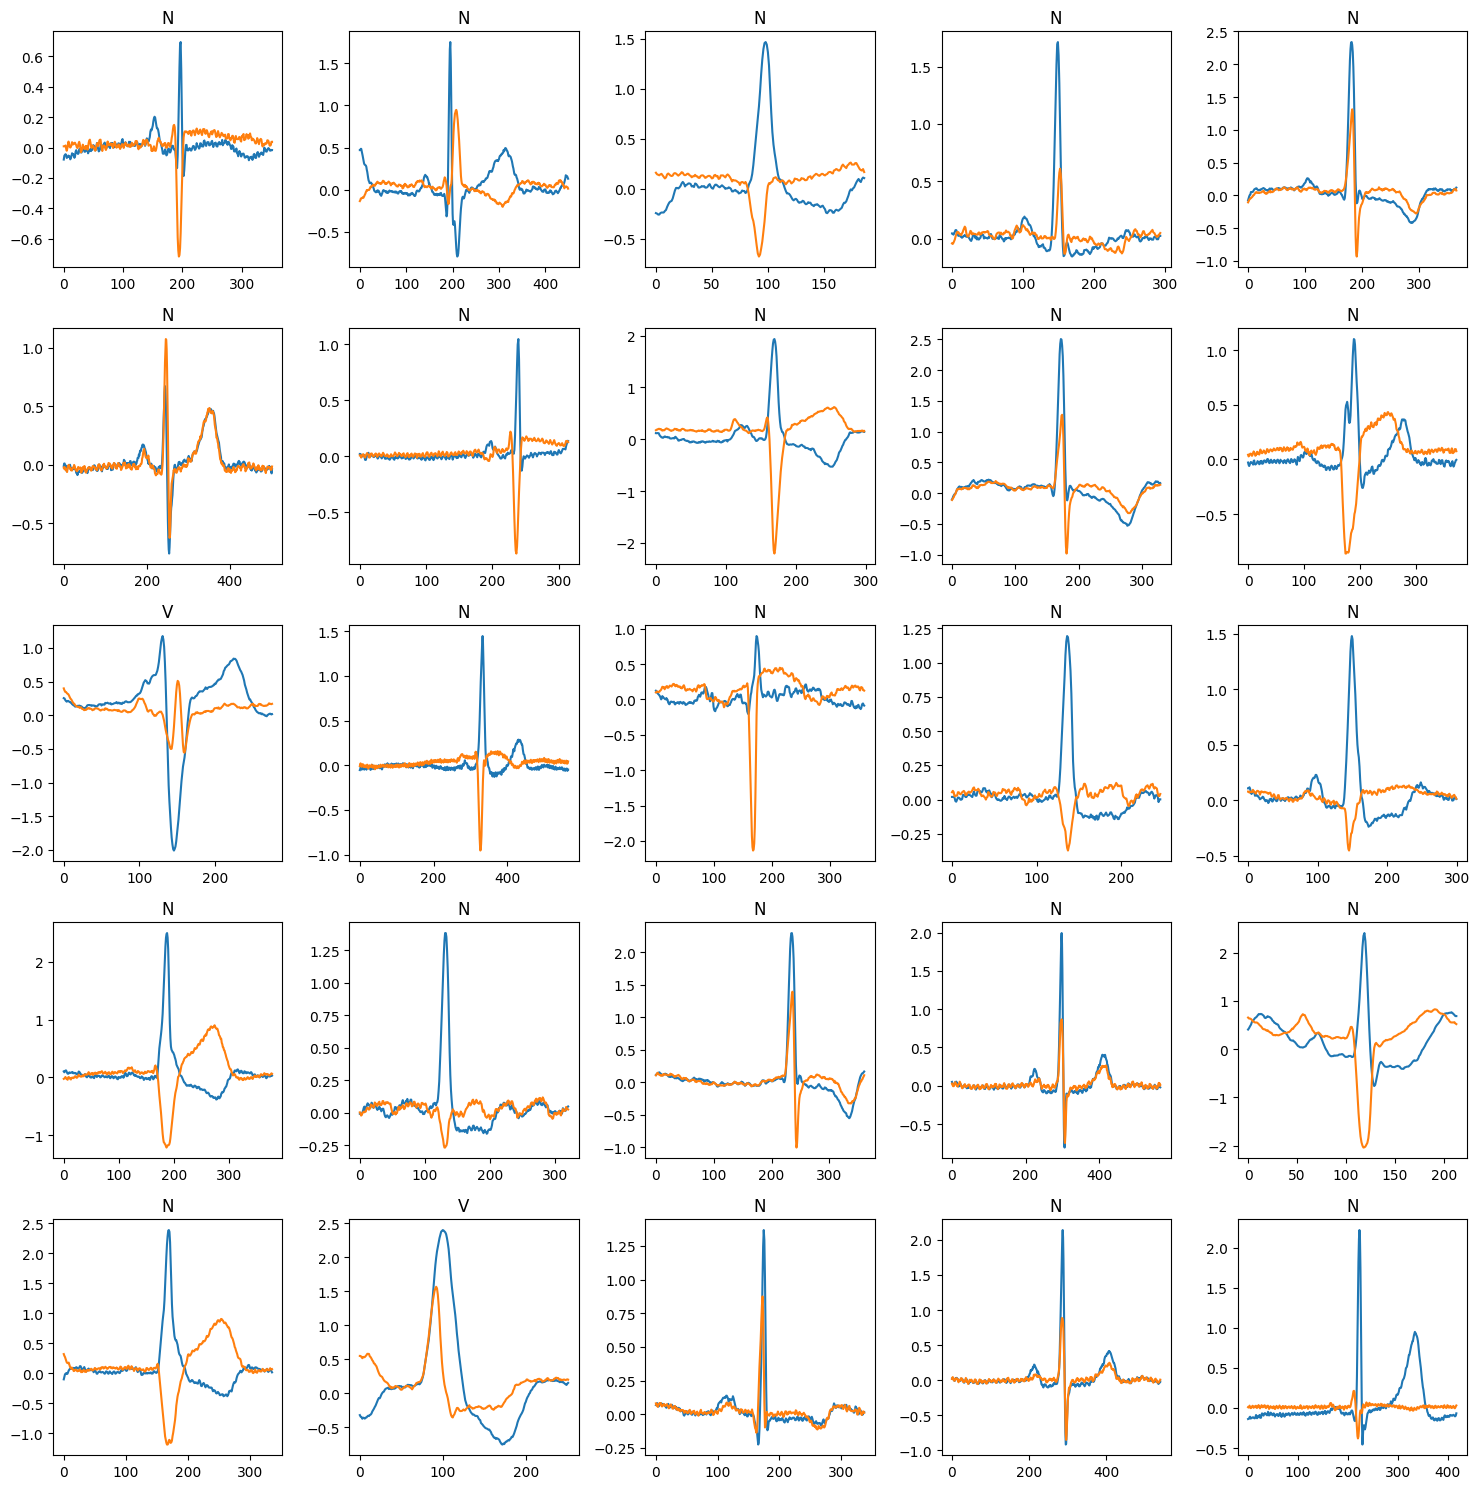

In [9]:
import random

# plot some processed samples in a grid
import matplotlib.pyplot as plt

fig, axes = plt.subplots(5, 5, figsize=(15, 15))
axes = axes.flatten()

random_indices = random.sample(range(len(processed_samples_test)), 25)

for i, idx in enumerate(random_indices):
    signal, label = processed_samples_test[idx]
    axes[i].plot(signal)
    axes[i].set_title(label)
    # axes[i].axis('off')

plt.tight_layout()
plt.show()

annotation.symbol len: 1874
annotation.symbol: ['+', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', '~', 'N', '|', 'N', 'N', 'N', 'N', '~', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N

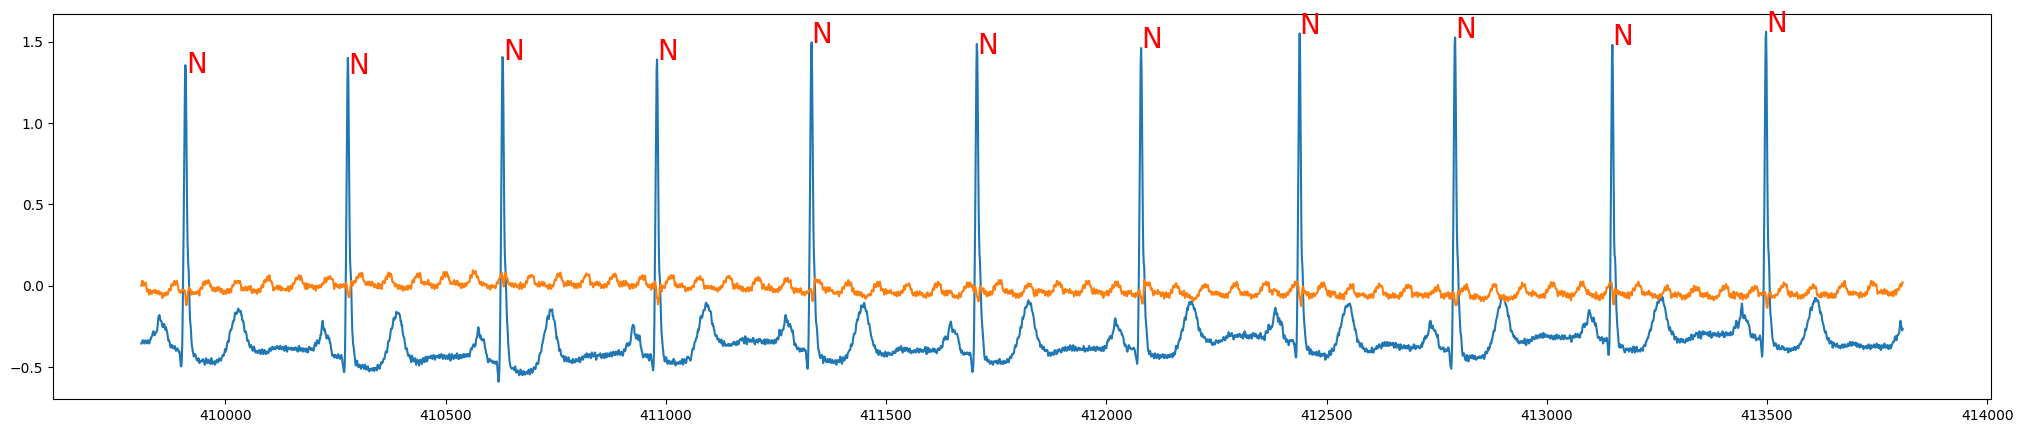

In [10]:
import neurokit2 as nk

patient = 101
annotation = wfdb.rdann(f'data/raw/{patient}', 'atr')
print(f'annotation.symbol len: {len(annotation.symbol)}')
print(f'annotation.symbol: {annotation.symbol}')
print(f'annotation.sample len: {len(annotation.sample)}')
print(f'annotation.sample: {annotation.sample}')

signal, _ = wfdb.rdsamp(f'data/raw/{patient}')
print(f'signal len: {len(signal)}')
print(f'signal shape: {signal.shape}')

min_idx = 412809 - 3000
max_idx = 412809 + 1000

r_peaks = [s for s in annotation.sample if s < max_idx and s > min_idx]
print(f'r_peaks: {r_peaks}')

# signals, waves = nk.ecg_delineate(signal[min_idx:max_idx, 0], r_peaks, show=False, sampling_rate=360)

#nk.events_plot([waves["ECG_P_Offsets"]], signal[:2000, 0])
#print(f'waves: {waves.keys()}')

import matplotlib.pyplot as plt

# Plot the signal
plt.figure(figsize=(25, 5))
plt.plot(range(min_idx, max_idx), signal[min_idx:max_idx])
# print(f'signal[{min_idx}:{max_idx}, 0]: {signal[min_idx:max_idx,]}')

# Plot the annotation symbols
for symbol, sample in zip(annotation.symbol, annotation.sample):
    if sample < max_idx and sample > min_idx:  # Only plot symbols within the first 1000 samples
        print(f'{sample}: {symbol}')
        plt.text(sample, signal[sample, 0], symbol, color='red', fontsize=20)

plt.show()

array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

<Figure size 2500x500 with 0 Axes>

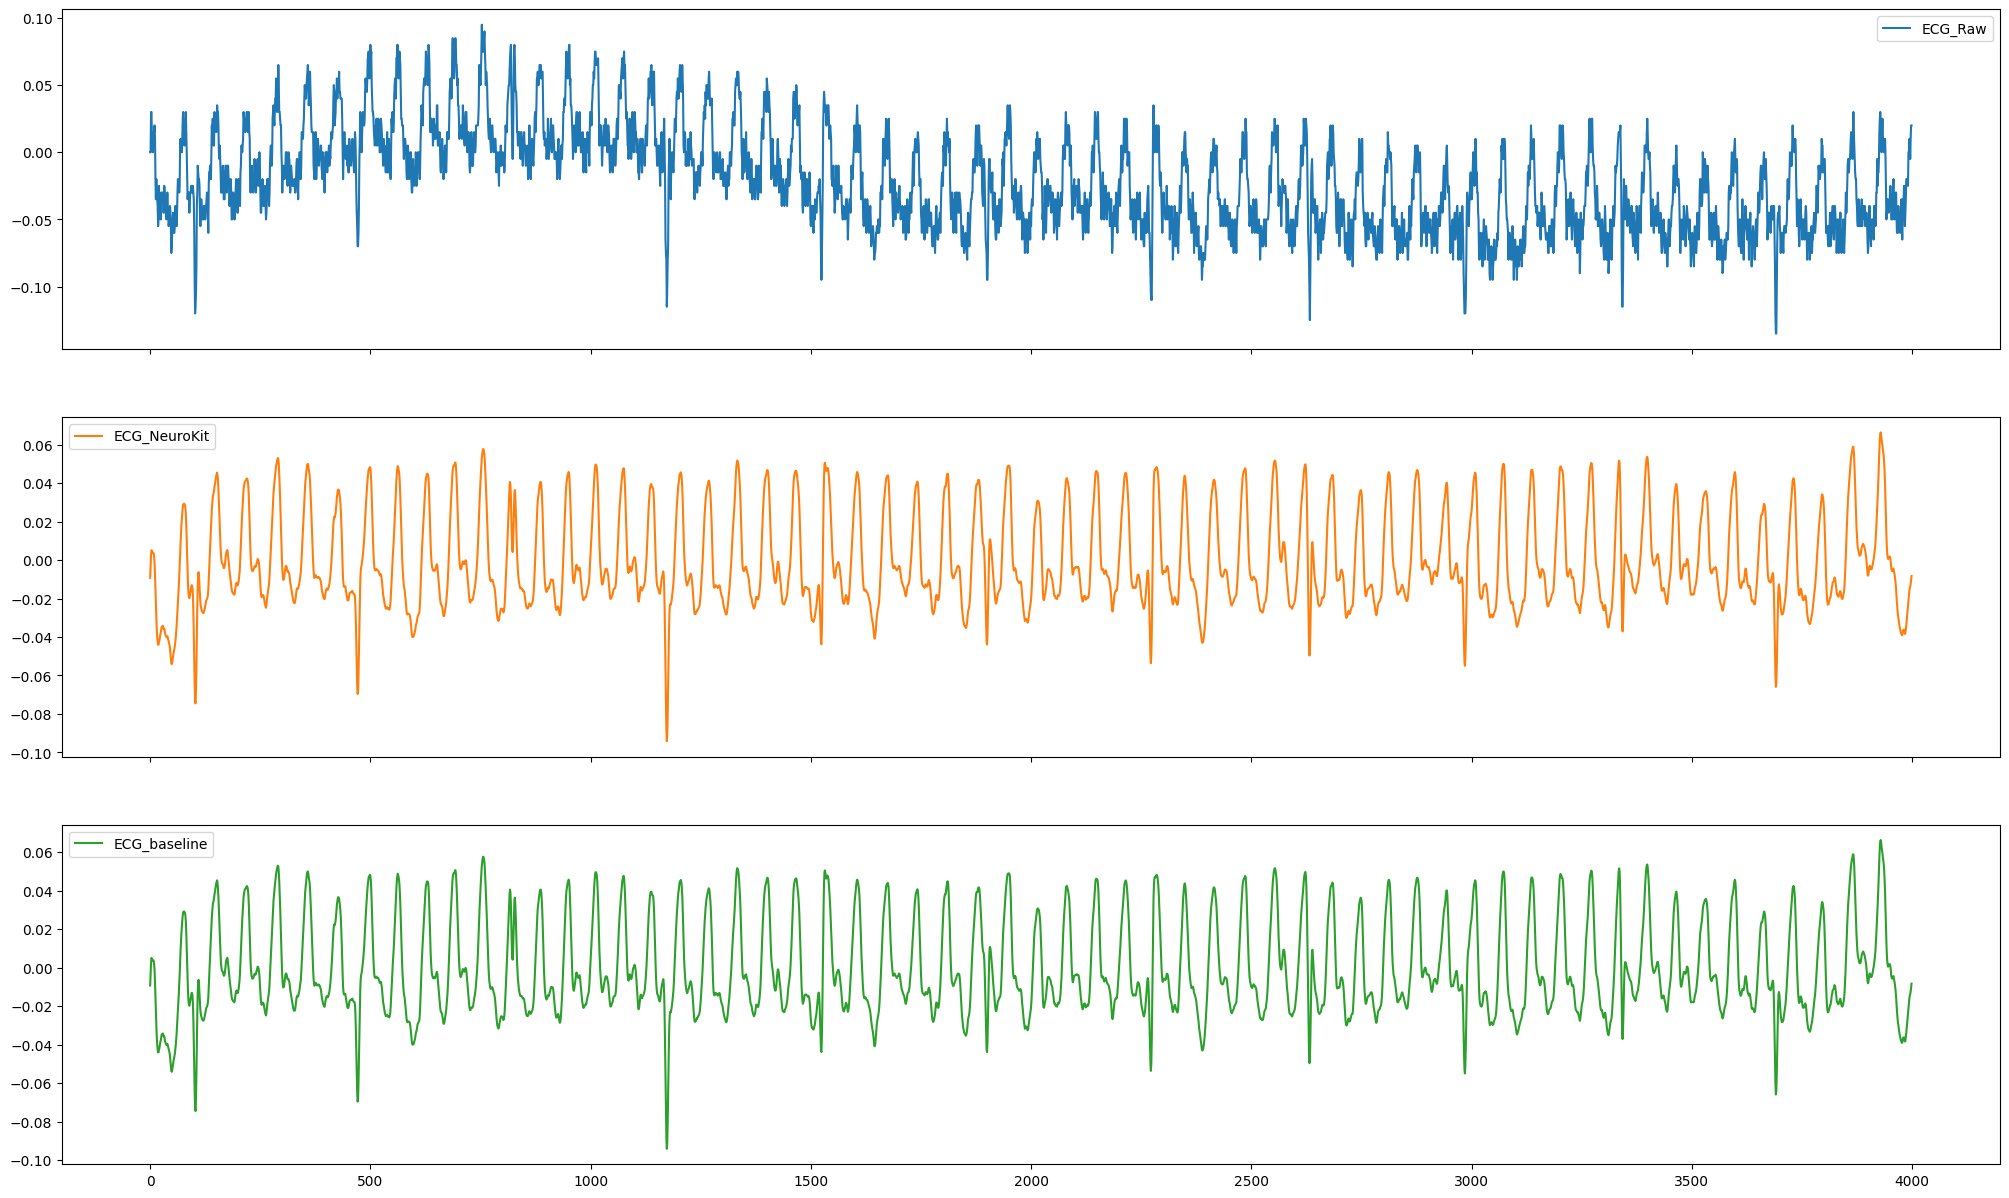

In [11]:
import matplotlib.pyplot as plt
from pandas import DataFrame

# Plot the signal
plt.figure(figsize=(25, 5))

ecg = signal[min_idx:max_idx, 1]

# remove baseline wander

signals = DataFrame({
    "ECG_Raw" : ecg,
    "ECG_NeuroKit" : nk.ecg_clean(ecg, sampling_rate=250, method="neurokit"),
    "ECG_baseline" : nk.ecg_clean(ecg, sampling_rate=250, method="nk"),
})

signals.plot(subplots=True, figsize=(25, 15))



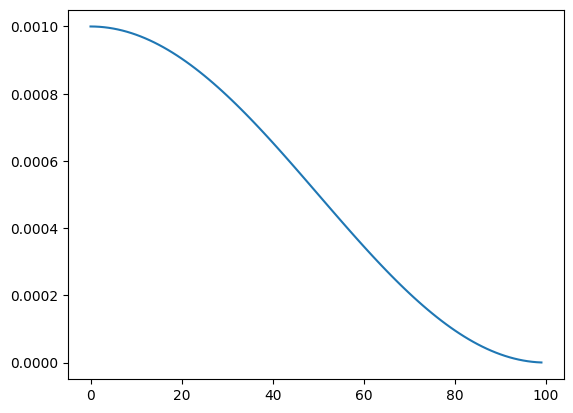

In [12]:
# simulate lr cosine alnnealing
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

optimizer = torch.optim.Adam([torch.tensor([1.0])])
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)  # T_max is the number of iterations for the first half of the cycle

lrs = []
for i in range(100):
    optimizer.step()
    lrs.append(optimizer.param_groups[0]['lr'])
    scheduler.step()

plt.plot(lrs)
